# STACKING

In [0]:
import itertools
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from sklearn import datasets

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB 
from sklearn.ensemble import RandomForestClassifier
#from sklearn.tree import DecisionTreeClassifier

from mlxtend.classifier import StackingClassifier

from sklearn.model_selection import cross_val_score, train_test_split

from mlxtend.plotting import plot_learning_curves
from mlxtend.plotting import plot_decision_regions

In [39]:
import pandas as pd
credit = pd.read_csv('credit.csv')
credit.head()

,checking_balance,months_loan_duration,credit_history,purpose,amount,savings_balance,employment_duration,percent_of_income,years_at_residence,age,other_credit,housing,existing_loans_count,job,dependents,phone,default
0,< 0 DM,6,critical,furniture/appliances,1169,unknown,> 7 years,4,4,67,none,own,2,skilled,1,yes,no
1,1 - 200 DM,48,good,furniture/appliances,5951,< 100 DM,1 - 4 years,2,2,22,none,own,1,skilled,1,no,yes
2,unknown,12,critical,education,2096,< 100 DM,4 - 7 years,2,3,49,none,own,1,unskilled,2,no,no
3,< 0 DM,42,good,furniture/appliances,7882,< 100 DM,4 - 7 years,2,4,45,none,other,1,skilled,2,no,no
4,< 0 DM,24,poor,car,4870,< 100 DM,1 - 4 years,3,4,53,none,other,2,skilled,2,no,yes


In [40]:
credit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 17 columns):
checking_balance        1000 non-null object
months_loan_duration    1000 non-null int64
credit_history          1000 non-null object
purpose                 1000 non-null object
amount                  1000 non-null int64
savings_balance         1000 non-null object
employment_duration     1000 non-null object
percent_of_income       1000 non-null int64
years_at_residence      1000 non-null int64
age                     1000 non-null int64
other_credit            1000 non-null object
housing                 1000 non-null object
existing_loans_count    1000 non-null int64
job                     1000 non-null object
dependents              1000 non-null int64
phone                   1000 non-null object
default                 1000 non-null object
dtypes: int64(7), object(10)
memory usage: 132.9+ KB


In [41]:
credit.describe()

,months_loan_duration,amount,percent_of_income,years_at_residence,age,existing_loans_count,dependents
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,20.903000,3271.258000,2.973000,2.845000,35.546000,1.407000,1.155000
std,12.058814,2822.736876,1.118715,1.103718,11.375469,0.577654,0.362086
min,4.000000,250.000000,1.000000,1.000000,19.000000,1.000000,1.000000
25%,12.000000,1365.500000,2.000000,2.000000,27.000000,1.000000,1.000000
50%,18.000000,2319.500000,3.000000,3.000000,33.000000,1.000000,1.000000
75%,24.000000,3972.250000,4.000000,4.000000,42.000000,2.000000,1.000000
max,72.000000,18424.000000,4.000000,4.000000,75.000000,4.000000,2.000000


In [0]:
credit.drop('phone',axis = 1, inplace = True)
credit.drop('purpose',axis = 1, inplace = True)
credit.drop('employment_duration',axis = 1, inplace = True)
credit.drop('checking_balance',axis = 1, inplace = True)
credit.drop('savings_balance',axis = 1, inplace = True)

# converting categorical features

In [0]:
default = pd.get_dummies(credit['default'],drop_first = True)
job = pd.get_dummies(credit['job'],drop_first = True)
housing = pd.get_dummies(credit['housing'],drop_first = True)
other_credit = pd.get_dummies(credit['other_credit'],drop_first = True)
credit_history = pd.get_dummies(credit['credit_history'],drop_first = True)

In [0]:
credit.drop(['default','job','housing','other_credit','credit_history'],axis = 1, inplace = True )
credit = pd.concat([credit,default,job,housing,other_credit,credit_history],axis = 1)

In [45]:
credit.head()

,months_loan_duration,amount,percent_of_income,years_at_residence,age,existing_loans_count,dependents,yes,skilled,unemployed,unskilled,own,rent,none,store,good,perfect,poor,very good
0,6,1169,4,4,67,2,1,0,1,0,0,1,0,1,0,0,0,0,0
1,48,5951,2,2,22,1,1,1,1,0,0,1,0,1,0,1,0,0,0
2,12,2096,2,3,49,1,2,0,0,0,1,1,0,1,0,0,0,0,0
3,42,7882,2,4,45,1,2,0,1,0,0,0,0,1,0,1,0,0,0
4,24,4870,3,4,53,2,2,1,1,0,0,0,0,1,0,0,0,1,0


# Data preparation and model building

In [0]:
X = credit.iloc[:,[0,6]].values
y = credit.iloc[:,7].values



In [0]:
# Level-0 - Base Classifiers
clf1 = KNeighborsClassifier(n_neighbors=1)
clf2 = RandomForestClassifier(random_state=1)
#clf2 = DecisionTreeClassifier(random_state=1)
clf3 = GaussianNB()

# Level-1 - Meta Classifier
lr = LogisticRegression()

# Stacking Ensemble
sclf = StackingClassifier(classifiers=[clf1, clf2, clf3], meta_classifier=lr)


label = ['KNN', 'Random Forest', 'Naive Bayes', 'Stacking Classifier']
#label = ['KNN', 'Decision Tree', 'Naive Bayes', 'Stacking Classifier']

# List of all the classifiers
clf_list = [clf1, clf2, clf3, sclf]



Accuracy: 0.59 (+/- 0.02) [KNN]


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Accuracy: 0.68 (+/- 0.01) [Random Forest]
Accuracy: 0.70 (+/- 0.02) [Naive Bayes]


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy: 0.69 (+/- 0.02) [Stacking Classifier]


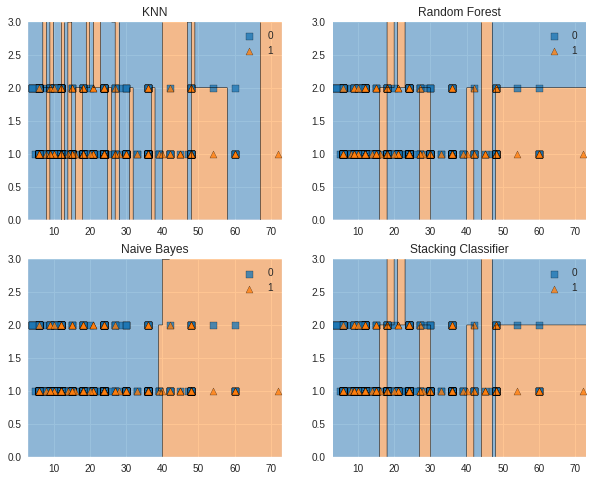

In [69]:

# Two empty lists to keep track of statictics (mean and standard deviation of the scores of various classifiers)
clf_cv_mean = []
clf_cv_std = []

fig = plt.figure(figsize=(10,8))
gs = gridspec.GridSpec(2, 2)
grid = itertools.product([0,1],repeat=2)

for clf, label, grd in zip(clf_list, label, grid):
       
    scores = cross_val_score(clf, X, y, cv=3, scoring='accuracy') # 3-fold cross-validation
    print ("Accuracy: %.2f (+/- %.2f) [%s]" %(scores.mean(), scores.std(), label))
    clf_cv_mean.append(scores.mean())  # mean acccuracy score for the 3-fold cross validation...save in a list
    clf_cv_std.append(scores.std()) # standard deviation of the scores for the 3-fold cross validation...save in a list
        
    clf.fit(X, y)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X, y=y, clf=clf)
    plt.title(label)

plt.show()

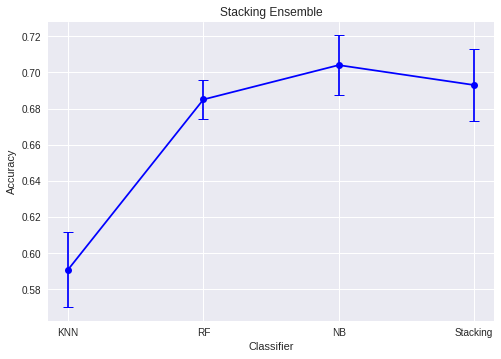

In [70]:
# Plot classifier accuracy    
plt.figure()
(_, caps, _) = plt.errorbar(range(4), clf_cv_mean, yerr=clf_cv_std, c='blue', fmt='-o', capsize=5)
for cap in caps:
    cap.set_markeredgewidth(1)                                                                                                                                
plt.xticks(range(4), ['KNN', 'RF', 'NB', 'Stacking'])        
#plt.xticks(range(4), ['KNN', 'DT', 'NB', 'Stacking'])        

plt.ylabel('Accuracy')
plt.xlabel('Classifier')
plt.title('Stacking Ensemble')
plt.show()

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

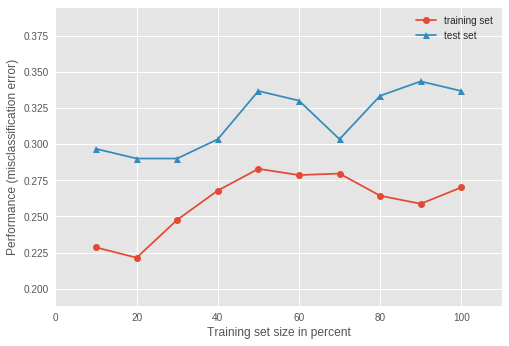

In [71]:
#plot learning curves
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
plt.figure()
plot_learning_curves(X_train, y_train, X_test, y_test, sclf, print_model=False, style='ggplot')
plt.show()

# **Adaboost**

In [0]:
import itertools
import numpy as np

#import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from sklearn import datasets

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_val_score, train_test_split

from mlxtend.plotting import plot_learning_curves
from mlxtend.plotting import plot_decision_regions

In [0]:
# Decision Stump as the weak base learner    
clf = DecisionTreeClassifier(criterion='entropy', max_depth=1)

# Number of base estimators
num_est = [1, 2, 3, 10]  

label = ['AdaBoost (n_est=1)', 'AdaBoost (n_est=2)', 'AdaBoost (n_est=3)', 'AdaBoost (n_est=10)']

**CREATE ADABOOST MODEL**

/usr/local/lib/python3.6/dist-packages/matplotlib/contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


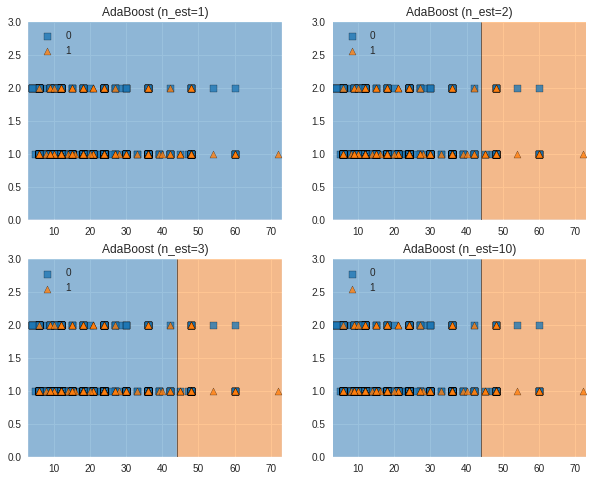

In [75]:

fig = plt.figure(figsize=(10, 8))
gs = gridspec.GridSpec(2, 2)
grid = itertools.product([0,1],repeat=2)

for n_est, label, grd in zip(num_est, label, grid):     
    boosting = AdaBoostClassifier(base_estimator=clf, n_estimators=n_est)   
    boosting.fit(X, y)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X, y=y, clf=boosting, legend=2)
    plt.title(label)

plt.show()

**PERFORMANCE  EVALUATION**

**Check Accuracy of Adaboost on 20 randomly selected number of base learners.
**

In [0]:
#Ensemble Size
num_est = map(int, np.linspace(1,100,20))

num_list=[]
#print(num_est)
#print(type(num_est))

bg_clf_cv_mean = []
bg_clf_cv_std = []
for n_est in num_est:
    num_list.append(n_est)

    ada_clf = AdaBoostClassifier(base_estimator=clf, n_estimators=n_est)
    scores = cross_val_score(ada_clf, X, y, cv=3, scoring='accuracy')
    
    bg_clf_cv_mean.append(scores.mean())
    bg_clf_cv_std.append(scores.std())

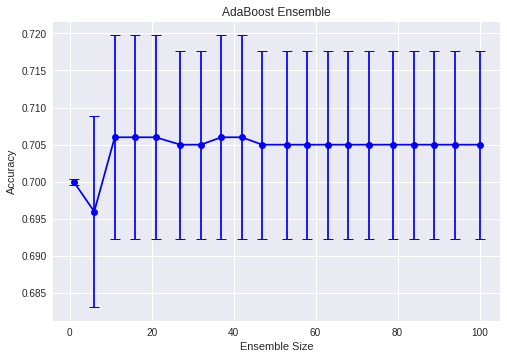

In [78]:
plt.figure()
(_, caps, _) = plt.errorbar(num_list, bg_clf_cv_mean, yerr=bg_clf_cv_std, c='blue', fmt='-o', capsize=5)
for cap in caps:
    cap.set_markeredgewidth(1)                                                                                                                                
plt.ylabel('Accuracy')
plt.xlabel('Ensemble Size')
plt.title('AdaBoost Ensemble')
plt.show()